<center><h1> Optimal Siting, Sizing and Bid Scheduling of a Price-Maker Battery on a Nodal Wholesale Market </h1></center>

* **Authors of the code**: [Guillaume Goujard](https://github.com/GuillaumeGoujard), Kieran Janin

<!-- * _**Referenced paper**: ..._
* _**More information**: ..._ -->

<!-- ## Contents (idea of a structure)

1. [Preliminary Study](#PreliminaryStudy) <br>
    1.1. [Data Loading](#DataLoading) <br>
    1.2. [Missing Values](#MissingValues)<br>
    1.3. [Data Preprocessing](#DataPreprocessing)<br>
    1.4. [Exploratory Data Analysis (EDA)](#ExploratoryDataAnalysisEDA)<br>
2. [Outlier Analysis](#OutlierAnalysis) <br>
    2.1. [Outlier Detection](#OutlierDetection) <br>
    2.2. [Outlier Correction](#OutlierCorrection)<br>
    2.3. [Outlier Removal](#OutlierRemoval)<br>
3. [Further Processing](#FurtherProcessing) <br>
    3.1. [Target Transformation](#TargetTransformation) <br>
    3.2. [Feature Engineering](#FeatureEngineering)<br>
    3.3. [Zone Encoding](#ZoneEncoding)<br>
    3.4. [Data Downcasting](#DataDowncasting)<br>
    3.5. [Feature Correlations](#FeatureCorrelations)<br>
4. [Modeling](#Modeling) <br>
    4.1. [Data Splitting](#DataSplitting) <br>
    4.2. [Regressors](#Regressors)<br>
    4.3. [Validation](#Validation)<br>
    4.4. [Feature Importances](#FeatureImportances)<br>
5. [Prediction](#Prediction)<br> -->

The objective of the following notebook is to present the code that lead to the results presented in the section 3 of the ACC2021 "Optimal Siting, Sizing and Bid Scheduling of a Price-Maker Battery on a Nodal Wholesale Market" paper. 

Please read the README for the requirements as well as the description of the architecture of the code.

In [1]:
# To update conda
# conda update -n base -c defaults conda

In [2]:
# To install table of contents and execute time
# conda install -c conda-forge jupyter_contrib_nbextensions

## 1) Set-Up

In [3]:
# Preliminary setup to recognize all modules
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Standard Packages

In [4]:
import numpy as np
import pandas as pd

### Custom Packages

In [5]:
%%capture 
# To suppress output

import lmpnz.JupyterRessources.dataPackage as dataPackage #
from lmpnz.GuillaumeExample import economic_dispatch #
import lmpnz.JupyterRessources.NZGridVizualization as nzgridvisu #

from lmpnz import stored_path #

from lmpnz.Network.PriceBids.Generator.Generator import Generator #
from lmpnz.Network.Topology.Topology import Topology as topology #
import lmpnz.Network.Topology.Topology as Topology #
from lmpnz.JupyterRessources import averagecongestion #
from lmpnz.JupyterRessources import tablescore #
 
from lmpnz.JupyterRessources import plotPrograms as plotprog #

## 2) Walkthrough

Here is a walkthrough of the functions you need to run to obtain the graphs and tables presented in the paper.

### a) Preliminary function and inputs

In [6]:
def baseline_prices(day, Horizon_T,  H, h, Mn, b, P_max, P_min, d):
    n = d.shape[0]  # number of nodes

    """
    Find lambdas for the day (they will be deemed exogenous)
    """
    lambdas = np.zeros((n, Horizon_T))
    gammas = np.zeros(Horizon_T)
    for j in range(Horizon_T):
        """
        Here is a new optimization framework which is rigoursely the same as devised in the algorithm, 
        WARNING this is just for time period j.

        We input the c and q, the price and quantity offered by the battery. Here 0,0 because we want the LMPs
        without the battery
        """
        c = 0
        q = 0
        model = economic_dispatch.run_ED_1period(d[:, j], b[:, j], P_max[:, j], P_min[:, j], c, q, H, h, Mn)
        for k in range(n):
            lambdas[k, j] = model.dual[model.injection_definition[k]]  # here we store the dual variables of the injection definition constraint

        gammas[j] = model.dual[model.injection_balance]

    return lambdas, gammas

Input used for the article: 2nd day of September 2019. 

In [7]:
day = 2
Horizon_T = 48
# select_investment_horizon = False

### b) Load the New Zealand grid topology

The NZ network is comprised of 258 nodes.
With  most  of  the  nodes  being  relatively  minor,  we aggregate these nodes in 19 main nodes and we connect them with transmission lines forming the “backbone” ofthe transmission system. A swing node(B∗, 0) is set between the two islands.

- create a topology object "AMB network" which is loading the NewZealand grid topology
- From the object, get the Shift-factor matrix H and line capacity limits h

In [8]:
AMB_network = topology(network="ABM")
H, h = AMB_network.H, AMB_network.h

- aggregate and add the 19 loads to "AMB network" 
- aggregate and add the generators to "AMB network" 

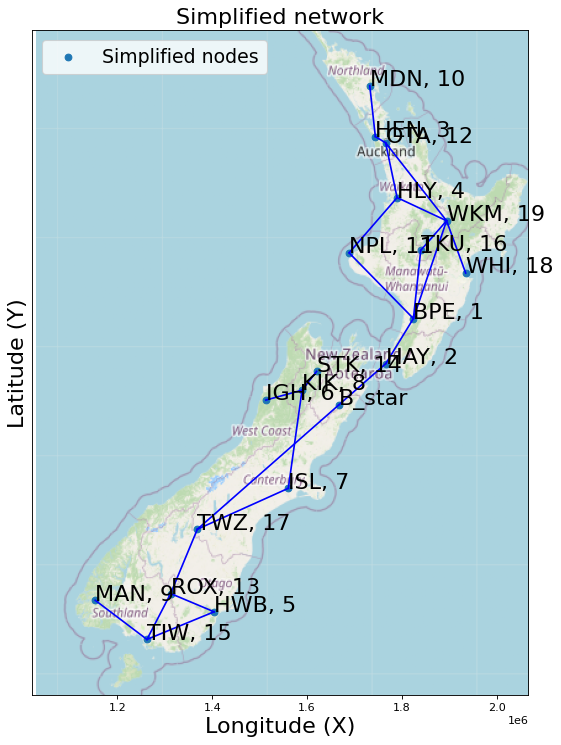

In [9]:
AMB_network = Topology.add_loads_to_topology(AMB_network)
AMB_network = Topology.add_generators_to_topology(AMB_network)

#plot the grid
nzgridvisu.plot_19_nodes()

### c) Adjust demand

The load curves of the simplified network come from  aggregating  demand  at  the  interior  nodes.  We multiplied the load at node 10 by 12, so that for some hours,  the  demand  exceeds  the  capacity  of  the  singleline  connecting  nodes  10  to  3  (see  Fig  3,  North  end). We  applied  a  factor  of  1.3  to  the  rest  of  the  loads  to favor  congestion  and  to  prevent  infeasible  formulation due to high self-schedule volumes.

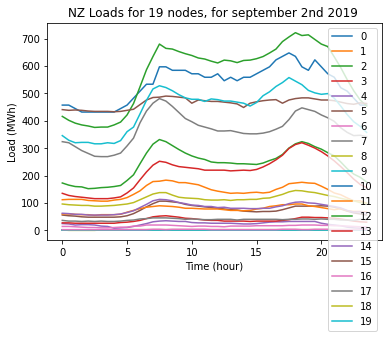

load historical data loaded


In [11]:
d = dataPackage.get_load_matrix(AMB_network, day, Horizon_T)
d = dataPackage.tweak_d(d, load_factor=1.3, index_to_tweak=10, load_factor_for_node=12.7)
plotprog.plot_nodal_demand(d)
print("load historical data loaded")

### d) Create swing generator on MDN and load historical bid data

For each generator, $P_{min}$ was taken as the volume bid at \\$0 and $P_{max}$ as the maximum of the cumulative volume offered on the market. Finally $a$ was set to the weighted average of the bidding prices for bids over \\$0. However, with these bids the simulated LMPs are unrealistic and do not match the actual price data. We adjust the bidding prices $a$ so that the simulated marginal cost overfit the realized marginal cost. We also added a swing generator at node 10 with specified bidding prices such that the simulated congestion charge at this node fits the realized values when congestion occurs.

In [12]:
# Average congestion on MDN
node_name = "MDN"
_ = AMB_network.add_generator(Generator("swing_generator", node_name, 0, 0, Pmax=200, Pmin=0, marginal_cost=[0,0]))

From the actual bidding data we get b, the average bid price for each actor and at each period, P_max and P_min.

In [13]:
b, P_max, P_min = dataPackage.get_producers_matrices(AMB_network, day, Horizon_T, random_a=False)
print("historical bids loaded")

historical bids loaded


In [14]:
Mn = AMB_network.Mn

### e) Get the actual LMPs (without Battery)

With these bid data and our assumptions on the market structure, the market prices are not plausible and way off to what actually happened. Note that there is no congestion as the swing generator at node 10 is bidding at \\$0 and is therefore economically dispatched.

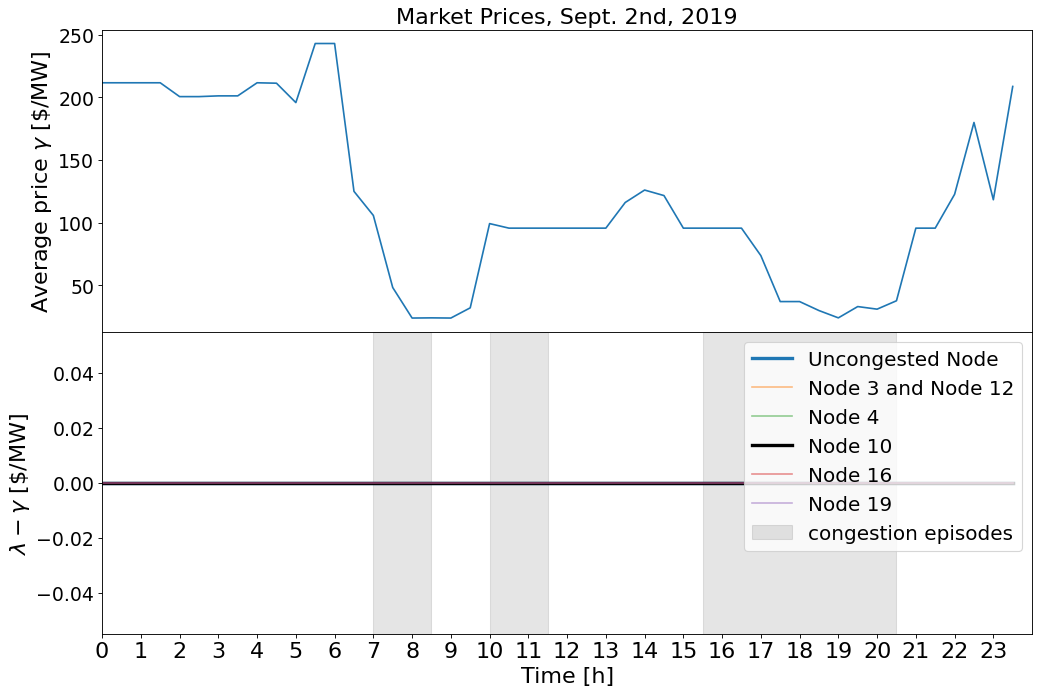

In [15]:
lambdas, gammas = baseline_prices(day, Horizon_T, H, h, Mn, b, P_max, P_min, d)
plotprog.plot_lambdas_gammas(lambdas, gammas)

We therefore adjust the bids so that the simulated LMPs are the actual LMPs.

In [16]:
actual_lmps = pd.read_csv(stored_path.main_path + "/data/historicaLMPs/Wholesale_price_trends_20200825111248.csv")
actual_system_lambda = actual_lmps["Price ($/MWh)"].values
offset = actual_system_lambda - gammas
b = b+offset

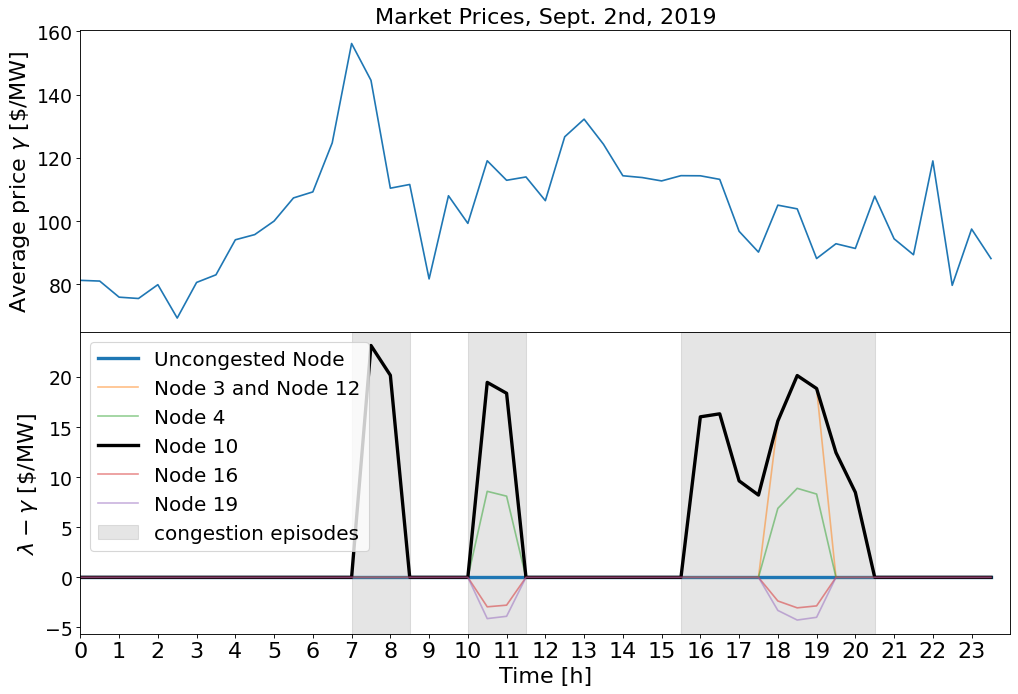

In [17]:
_, congestion_charge_node = averagecongestion.get_average_congestion_charge(node="MDN1101")
congestion_charge_node = congestion_charge_node.sort_values(by="Trading_period")
b[-1] = congestion_charge_node["Price"].values

lambdas, gammas = baseline_prices(day, Horizon_T, H, h, Mn, b, P_max, P_min, d)
plotprog.plot_lambdas_gammas(lambdas, gammas)

### f) Table of results

Given a cost for the battery (180\\$ /day /MWh) and a power rate (here 1 means that the battery can fully discharge in 1 period = 30 min, 2 means 60 min), we compute the optimal schedule according to a price-taker and maker program and returns:

    - the optimal energy capacity for the price maker programe z_cap (MWh), 
    - the depreciated profits: arbitrage - battery cost (\\$), 
    - the value of the arbitrage for the price maker program (\\$), 
    - the value of the price-taker expected arbitrage (\\$),
    - the value of the price-taker actual arbitrage (\\$).

We implemented the price-maker program (PM) following the article and report on the optimal capacity, profits and revenue. A price-taker program (PT) returns the unit revenue, i.e, the revenue for 1MWh of installed capacity. We also report the expected and actual revenue of a PT battery having the optimal PM capacity. These two differ since the actual realization of the bidding schedule will move prices and yields a lower actualized revenue. The nodes outside the congested area yield a null capacity by design of the penalty. That is, the unit revenue on those nodes is worth \\$173 which is smaller than the penalty of \\$180. The comparative and rounded results for the congested nodes are displayed in df. We note that node 10 would be chosen to install a 35MWh battery by PM. Node 10 would also be chosen by PT, only with no information on its size. PT would next select nodes 4 instead of 3 (or 12) because of higher unit revenue. Interestingly, PM informs us that node 4 would yield a smaller revenue as node 4 must be less congested. Finally, we notice a significant offset between actual and expected revenue for PT, illustrating the drawbacks of the price-taker assumption in congested networks. 

In [18]:
args = [d, b, P_max, P_min, H, h, Mn]
df = tablescore.compute_table_score(lambdas, 180, *args, power_rate=2)

Price taker/maker program computed for Node  1
Price taker/maker program computed for Node  2
Price taker/maker program computed for Node  3
Price taker/maker program computed for Node  4
Price taker/maker program computed for Node  5
Price taker/maker program computed for Node  6
Price taker/maker program computed for Node  7
Price taker/maker program computed for Node  8
Price taker/maker program computed for Node  9
Price taker/maker program computed for Node  10
Price taker/maker program computed for Node  11
Price taker/maker program computed for Node  12
Price taker/maker program computed for Node  13
Price taker/maker program computed for Node  14
Price taker/maker program computed for Node  15
Price taker/maker program computed for Node  16
Price taker/maker program computed for Node  17
Price taker/maker program computed for Node  18
Price taker/maker program computed for Node  19


In [19]:
df.columns = [d+1 for d in df.columns]
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
node index,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
z_cap,0.0,0.0,45.5,16.4,0.0,0.0,0.0,0.0,0.0,35.0,0.0,45.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
depreciated profits,0.0,-0.0,576.2,60.0,-0.0,-0.0,-0.0,-0.0,-0.0,769.6,-0.0,576.2,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
arbitrage only pm,0.0,-0.0,8765.7,3015.6,-0.0,-0.0,-0.0,-0.0,-0.0,7069.6,-0.0,8765.7,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0
expected arbitrage pt,0.0,0.0,8958.5,3233.2,0.0,0.0,0.0,0.0,0.0,7680.3,0.0,8958.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
actual arbitrage pt,0.0,0.0,7482.1,2929.5,0.0,0.0,0.0,0.0,0.0,6759.7,0.0,7482.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
unit arbitrage pt,NaN,NaN,196.9,196.9,NaN,NaN,NaN,NaN,NaN,219.4,NaN,196.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### g) Optimal bidding schedule

Given a 100MWh/100MW battery storage, we plot in the following figure the cumulated profits (PT vs PM), the difference between the expected and actual revenue for PT at each time-step, the difference between the nodal price with PT and without (baseline BL) and finally the injection schedule for each program. The actual revenues for PT are inferior to PM revenues despite higher expectations. 

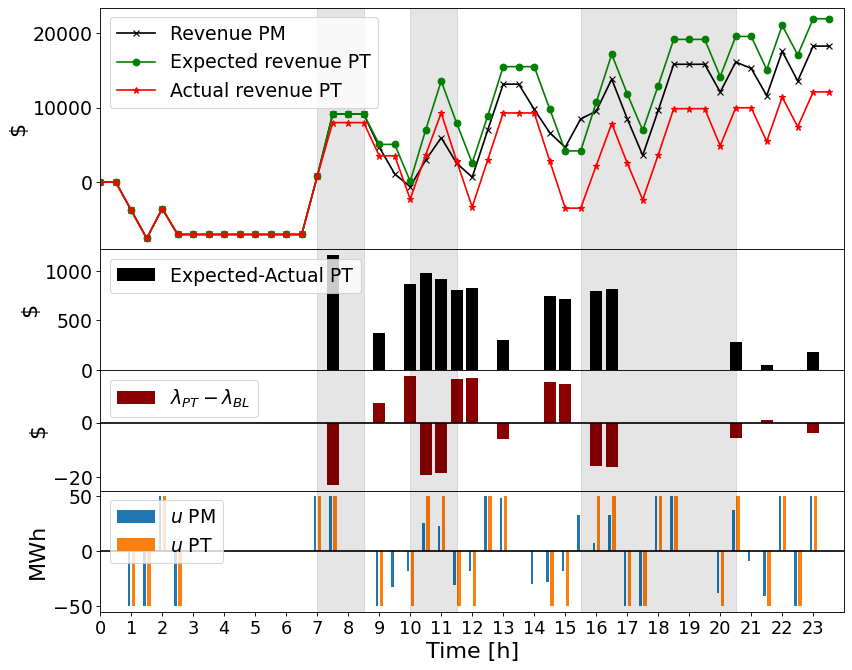

In [23]:
plotprog.plot_cum_prof(10, lambdas, 100, *args)

### h) Impact of battery capacity and the program on the LMP at node 10

In the following figure, we plot the average of the absolute difference of the PT and PM LMP at node 10 $\lambda_{10}^{PT}$, $\lambda_{10}^{PM}$ and the baseline LMP $\lambda_{10}^{BL}$, as a function of installed capacity. We notice that the price-taker assumption is invalidated even for a small capacity. We deduce from this figure that as soon as a congestion event occurs on node 10, a price-taker assumption cannot hold.  


1.0
12.0
23.0
34.0
45.0
56.0
67.0
78.0
89.0
100.0


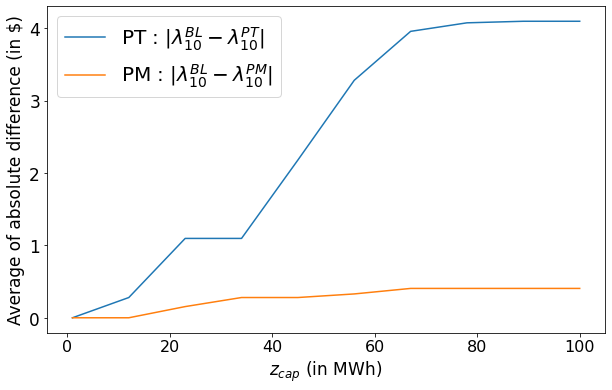

In [21]:
plotprog.plot_norm_2(*args, z_caps=np.linspace(1, 100, 10))
